In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random


from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc

2023-09-06 23:02:51.255699: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 23:02:51.286305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 23:02:51.855012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mediapipe.__version__)

TensorFlow v2.12.0
Mediapipe v0.10.3


In [3]:
gpu = tf.config.experimental.list_physical_devices('GPU')
gpu

2023-09-06 23:02:57.380446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-06 23:02:57.384350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-06 23:02:57.384473: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
dataset_df = pd.read_csv('train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (67208, 5)


In [5]:
dataset_df.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


In [6]:
# Fetch sequence_id, file_id, phrase from first row
sequence_id, file_id, phrase = dataset_df.iloc[0][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

sequence_id: 1816796431, file_id: 5414471, phrase: 3 creekhouse


In [7]:
# Fetch data from parquet file
# sample_sequence_df = pq.read_table(f"train_landmarks/{str(file_id)}.parquet",
#     filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()

# print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))
file_path = 'train_landmarks/{}.parquet'.format(str(file_id))

data = pd.read_parquet(file_path)
print(data.index.unique())

Index([1816796431, 1816825349, 1816862427, 1816909464, 1816967051, 1817123330,
       1817141095, 1817169529, 1817171518, 1817195757,
       ...
       1848104848, 1848114505, 1848125865, 1848131854, 1848135513, 1848141264,
       1848148361, 1848157014, 1848159052, 1848182207],
      dtype='int64', name='sequence_id', length=1000)


In [8]:
# data.head()

In [9]:
data_seq = data.loc[sequence_id]
data_seq.shape

(123, 1630)

In [10]:
# data_seq.head()

The hand landmark positions for ***3 creekhouse***

In [11]:
# Function create animation from images.

matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

In [12]:
# Extract the landmark data and convert it to an image using medipipe library.
# This function extracts the data for both hands.

mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils 
mp_drawing_styles = mediapipe.solutions.drawing_styles

def get_hands(seq_df):
    images = []
    all_hand_landmarks = []
    for seq_idx in range(len(seq_df)):
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

        right_hand_image = np.zeros((600, 600, 3))  # why 600? may be just to create a square frame with 600 black pixels?

        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        
        for x, y, z in zip(x_hand, y_hand, z_hand):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                right_hand_image,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_left_hand.*").values
        
        left_hand_image = np.zeros((600, 600, 3))
        
        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for x, y, z in zip(x_hand, y_hand, z_hand):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                left_hand_image,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])
    return images, all_hand_landmarks

In [13]:
# Get the images created using mediapipe apis
hand_images, hand_landmarks = get_hands(data_seq)
# Fetch and show the data for right hand
# create_animation(np.array(hand_images)[:, 0])

In [14]:
# hand_landmarks[3][0]

In order to avoind going between ***train.csv*** file and the ***perquet*** files we need to find a way to store the data into either `.npy` files or `tfrecord` files. 

In [15]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE
POSE

[13, 15, 17, 19, 21, 14, 16, 18, 20, 22]

# Create x,y,z label names from coordinates

In [16]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

In [17]:
FEATURE_COLUMNS = X + Y + Z
FEATURE_COLUMNS

['x_right_hand_0',
 'x_right_hand_1',
 'x_right_hand_2',
 'x_right_hand_3',
 'x_right_hand_4',
 'x_right_hand_5',
 'x_right_hand_6',
 'x_right_hand_7',
 'x_right_hand_8',
 'x_right_hand_9',
 'x_right_hand_10',
 'x_right_hand_11',
 'x_right_hand_12',
 'x_right_hand_13',
 'x_right_hand_14',
 'x_right_hand_15',
 'x_right_hand_16',
 'x_right_hand_17',
 'x_right_hand_18',
 'x_right_hand_19',
 'x_right_hand_20',
 'x_left_hand_0',
 'x_left_hand_1',
 'x_left_hand_2',
 'x_left_hand_3',
 'x_left_hand_4',
 'x_left_hand_5',
 'x_left_hand_6',
 'x_left_hand_7',
 'x_left_hand_8',
 'x_left_hand_9',
 'x_left_hand_10',
 'x_left_hand_11',
 'x_left_hand_12',
 'x_left_hand_13',
 'x_left_hand_14',
 'x_left_hand_15',
 'x_left_hand_16',
 'x_left_hand_17',
 'x_left_hand_18',
 'x_left_hand_19',
 'x_left_hand_20',
 'x_pose_13',
 'x_pose_15',
 'x_pose_17',
 'x_pose_19',
 'x_pose_21',
 'x_pose_14',
 'x_pose_16',
 'x_pose_18',
 'x_pose_20',
 'x_pose_22',
 'y_right_hand_0',
 'y_right_hand_1',
 'y_right_hand_2',
 'y_

In [18]:
# #Code for Augmentation
# def do_random_affine(xyz, scale=(0.8, 1.3), shift=(-0.08, 0.08), degree=(-16, 16), p=0.5):
#     if scale is not None:
#         scale = np.random.uniform(*scale)
#         xyz = scale*xyz

#     if shift is not None:
#         shift = np.random.uniform(*shift)
#         xyz = xyz + shift

#     if degree is not None:
#         degree = np.random.uniform(*degree)
#         radian = degree/180*np.pi
#         c = np.cos(radian)
#         s = np.sin(radian)
#         rotate = np.array([
#             [c,-s],
#             [s, c],
#         ]).T
#         xyz[..., :2] = xyz[..., :2] @rotate

#     return xyz

In [19]:
# do_random_affine()

# Cleaning

In [20]:
def find_sequence_with_less_than_30_frames(df):
    result = []
    
    # Group the DataFrame by 'sequence_id'
    grouped_df = df.groupby('sequence_id')
    
    # Check the number of frames for each group and keep 'sequence_id' with less than 10 frames
    for sequence_id, group in grouped_df:
        num_frames = len(group)
        if num_frames < 20:
            result.append(sequence_id)
    
    return result

In [21]:
def find_sequence_with_less_than_20_nonnans(df):
    sequences_to_drop = []
    for sequence_id, group in df.groupby('sequence_id'):
        non_nan_count = group[['x_right_hand_0']].count().sum()
        if non_nan_count < 10:
            sequences_to_drop.append(sequence_id)
    return sequences_to_drop


In [22]:
# def scale(matrix):
#     min_val = np.min(matrix)
#     max_val = np.max(matrix)
#     scaled_matrix = (matrix - min_val) / (max_val - min_val)

#     return scaled_matrix

In [23]:
# file_id = dataset_df.file_id.unique()[0]
# file_id

In [24]:
# parquet_df = pq.read_table("./train_landmarks/{}.parquet".format(str(file_id)),
#                               columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()

# parquet_df.shape

In [25]:
# sequences_to_drop = list(set(find_sequence_with_less_than_30_frames(parquet_df) \
#     + \
#     find_sequence_with_less_than_20_nonnans(parquet_df)))

In [26]:
# parquet_df = parquet_df[~parquet_df.index.isin(sequences_to_drop)]
# parquet_df.shape

In [27]:
# file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
# print(file_df.shape)

# file_df = file_df[~file_df['sequence_id'].isin(sequences_to_drop)]
# print(file_df.shape)

In [28]:
# len(sequences_to_drop)

In [29]:
# Set length of frames to 128
FRAME_LEN = 128

### Create indices for the co-ordinated {X,Y,Z} first and then create indices for the each hand and poses

In [30]:
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]

# Preprocessing and write the dataset as TFRecords

In [31]:
# # Set length of frames to 128
# FRAME_LEN = 128

# # Create directory to store the new data
# if not os.path.isdir("preprocessed"):
#     os.mkdir("preprocessed")
# else:
#     shutil.rmtree("preprocessed")
#     os.mkdir("preprocessed")

# # Loop through each file_id
# for file_id in dataset_df.file_id.unique():

#     print(file_id)
    
#     # Parquet file name
#     pq_file = 'train_landmarks/{}.parquet'.format(str(file_id))
#     # Filter train.csv and fetch entries only for the relevant file_id
#     file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
#     # Fetch the parquet file
#     parquet_df = pd.read_parquet(file_path, columns = ['sequence_id'] + FEATURE_COLUMNS)
#     print(parquet_df.shape)
    
#     # File name for the updated data
#     tf_file = f"preprocessed/{file_id}.tfrecord"
#     parquet_numpy = parquet_df.to_numpy()
#     # Initialize the pointer to write the output of 
#     # each `for loop` below as a sequence into the file.
#     with tf.io.TFRecordWriter(tf_file) as file_writer:
#         # Loop through each sequence in file.
#         for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
#             # Fetch sequence data
#             frames = parquet_numpy[parquet_df.index == seq_id]
            
#             # Calculate the number of NaN values in each hand landmark
#             r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
#             l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
#             no_nan = max(r_nonan, l_nonan)
            
#             if 2*len(phrase)<no_nan:
#                 features = {FEATURE_COLUMNS[i]: tf.train.Feature(
#                     float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
#                 features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
#                 record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
#                 file_writer.write(record_bytes)

In [ ]:
# Create directory to store the new data
if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")

# Loop through each file_id
for file_id in tqdm(dataset_df.file_id.unique()):
    # Parquet file name
    pq_file = "./train_landmarks/{}.parquet".format(file_id)

    
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = dataset_df.loc[dataset_df["file_id"] == file_id]

    # Fetch the parquet file
    parquet_df = pq.read_table("./train_landmarks/{}.parquet".format(str(file_id)),
                              columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()

    #drop some of the unwanted sequence ids
    concatenated_sequence_ids = find_sequence_with_less_than_30_frames(parquet_df) + find_sequence_with_less_than_20_nonnans(parquet_df)
    sequences_to_drop = list(set(concatenated_sequence_ids)) #take an union otherwise might get an error

    # Drop rows from the parquet dataframe
    parquet_df = parquet_df[~parquet_df.index.isin(sequences_to_drop)]

    # Drop rows from the train.csv for a particular file id where the sequence id matches the drop list
    file_df = file_df[~file_df['sequence_id'].isin(sequences_to_drop)]

    
    # File name for the updated data
    tf_file = f"preprocessed/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()
    parquet_numpy[np.isnan(parquet_numpy)] = 0 # replacxe the nans with 0s
    # parquet_numpy = scale(parquet_numpy)    
    print(parquet_numpy.shape)
    # Initialize the pointer to write the output of 
    # each `for loop` below as a sequence into the file.
    
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

# Load the Tfrecords

In [32]:
tf_records = dataset_df.file_id.map(lambda x: f'./preprocessed/{x}.tfrecord').unique()
# tf_records
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


# Load character_to_prediction json file
This json file contains a character and its value. We will add three new characters, "<" and ">" to mark the start and end of each phrase, and "P" for padding.

In [33]:
with open ("./character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)
    

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

In [34]:
# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

# Create function to parse data from TFRecord format
This function will read the TFRecord data and convert it to Tensors.

In [35]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

# Create function to convert the data
This function transposes and applies masks to the landmark coordinates. It also vectorizes the phrase corresponding to the landmarks using character_to_prediction_index.json.

In [36]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase

2023-09-06 23:03:30.983415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-06 23:03:30.983579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-06 23:03:30.983649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Use the functions we defined above to create the final dataset.
Train and validation split/Create the final datasets

In [37]:
batch_size = 64
train_len = int(0.7 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
print(train_ds)
print(valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 78), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 78), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>


In [39]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

In [40]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.2)
        self.dropout2 = layers.Dropout(0.2)

    # def call(self, inputs, training):
    #     attn_output = self.att(inputs, inputs)
    #     attn_output = self.dropout1(attn_output, training=training)
    #     out1 = self.layernorm1(inputs + attn_output)
    #     ffn_output = self.ffn(out1)
    #     ffn_output = self.dropout2(ffn_output, training=training)
    #     return self.layernorm2(out1 + ffn_output)

    def call(self, inputs, training):
        attn_output = inputs + self.att(self.layernorm1(inputs), self.layernorm1(inputs))
        out1 = self.dropout1(attn_output, training=training)

        out2 = self.layernorm2(out1)
        ffn_output = out1 + self.ffn(out2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return ffn_output

In [41]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim//num_heads
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.2)
        self.ffn_dropout = layers.Dropout(0.2)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

        target_norm = self.layernorm1(target)
        target_att = target + self.self_att(target_norm, target_norm, attention_mask=causal_mask)
        target_att = self.self_dropout(target_att, training = training)
        
        enc_out_norm = self.layernorm2(target_att)
        enc_out = target_att + self.enc_att(enc_out_norm, enc_out)
        enc_out = self.enc_dropout(enc_out, training = training)
        
        ffn_out_norm = self.layernorm3(enc_out)
        ffn_out = enc_out + self.ffn(ffn_out_norm)
        ffn_out = self.ffn_dropout(ffn_out, training = training)
        return ffn_out

    # def call(self, enc_out, target, training):
    #     input_shape = tf.shape(target)
    #     batch_size = input_shape[0]
    #     seq_len = input_shape[1]
        
    #     causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        
    #     target_att = self.self_att(target, target, attention_mask=causal_mask)
    #     target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        
    #     enc_out = self.enc_att(target_norm, enc_out)
    #     enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        
    #     ffn_out = self.ffn(enc_out_norm)
    #     ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
    #     return ffn_out_norm

In [42]:
class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=2,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [43]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        """Displays a batch of outputs after every 4 epoch

        Args:
            batch: A test batch
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

In [52]:
batch = next(iter(valid_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=2,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer = keras.optimizers.legacy.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=30)

Epoch 1/30
    543/Unknown - 16s 20ms/step - loss: 0.8789 - edit_dist: 1.2057target:     <javon friedman>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+93-37-33-93-703-03>

target:     <https://ent.people.com.cn>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <sutanaringerine/sereres.com>

target:     <cody zimmerman>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <inin corthen>

target:     <https://www.fdmtravel.dk>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+36-60-069-92-93-93>

target:     <pakscreen.ir/5345/>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+39-393-395-955>

target:     <forest andersen>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <90 nan ranest>

target:     <7011 boundry>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <711-303-1333>

target:     <+9928688872816985>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+99-18-88-58-758-48>

target:     <7189127183>PPPPPPPPPPPPPPPPPPPPPPPPP

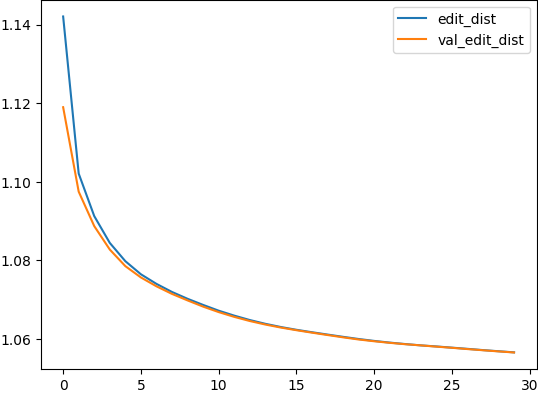

In [53]:
plt.plot(history.history['edit_dist'])
plt.plot(history.history['val_edit_dist'])
plt.legend(['edit_dist', 'val_edit_dist'])

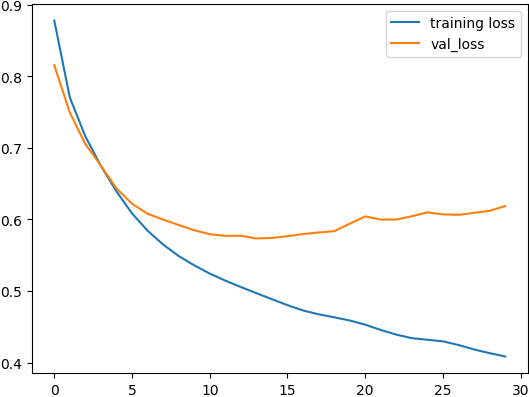

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])

In [55]:
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx
        # Load the feature generation and main models
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate(x, self.target_start_token_idx)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}
    
tflitemodel_base = TFLiteModel(model)

In [56]:
model.save_weights("model_06092023.h5")
# model.save("model_06092023.h5")

In [57]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()

# if not os.path.isdir("working"):
#     os.mkdir("working")model.save_weights("model_06092023.h5")
# else:
#     shutil.rmtree("working")
#     os.mkdir("working")

with open('./model_06092023.tflite', 'wb') as f:
    f.write(tflite_model)
    
infargs = {"selected_columns" : FEATURE_COLUMNS}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)

2023-09-06 23:20:23.782342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_7_input' with dtype float and shape [?,16,200]
	 [[{{node dense_7_input}}]]
2023-09-06 23:20:23.807119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'dense_7_input' with dtype float and shape [?,16,200]
	 [[{{node dense_7_input}}]]
2023-09-06 23:20:23.815676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16,200]
	

INFO:tensorflow:Assets written to: /tmp/tmp9j0o_5k4/assets


INFO:tensorflow:Assets written to: /tmp/tmp9j0o_5k4/assets
2023-09-06 23:21:37.112739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-06 23:21:37.112764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-06 23:21:37.112937: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9j0o_5k4
2023-09-06 23:21:37.142153: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-09-06 23:21:37.142184: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9j0o_5k4
2023-09-06 23:21:37.271497: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-06 23:21:38.000643: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp9j0o_5k4
2023-09-06 23:21:38.548563: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

In [58]:
!zip submission.zip  './model_06092023.tflite' './inference_args.json'

updating: inference_args.json (deflated 85%)
updating: model_06092023.tflite (deflated 29%)


In [59]:
interpreter = tf.lite.Interpreter("model_06092023.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("./character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

found_signatures = list(interpreter.get_signature_list().keys())

if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=batch[0][0])
prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
print(prediction_str)

848 85 natl nate
